In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from scipy.stats import linregress
from empiricaldist import Pmf
from empiricaldist import Cdf

In [2]:
brfss = pd.read_hdf('brfss.hdf5','brfss')
gss = pd.read_hdf('gss.hdf5','gss')


In [3]:
results = smf.ols('INCOME2 ~ _VEGESU1', data=brfss).fit()
results.params

Intercept    5.450700
_VEGESU1     0.204935
dtype: float64

In [6]:
results = smf.ols('realinc ~ educ',data=gss).fit()
results.params

Intercept   -11539.147837
educ          3586.523659
dtype: float64

In [7]:
results = smf.ols('realinc ~ educ + age',data=gss).fit()
results.params

Intercept   -16117.275684
educ          3655.166921
age             83.731804
dtype: float64

Text(0, 0.5, 'Income (1986 $)')

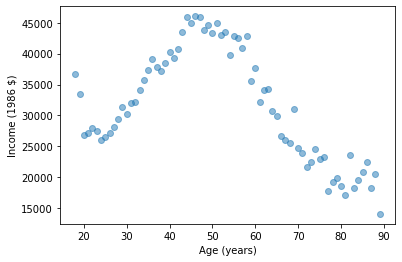

In [10]:
grouped = gss.groupby('age')
mean_income_by_age = grouped['realinc'].mean()
plt.plot(mean_income_by_age,'o',alpha=.5)
plt.xlabel('Age (years)')
plt.ylabel('Income (1986 $)')

In [11]:
gss['age2'] = gss['age']**2
gss['educ2'] = gss['educ']**2


In [12]:
model = smf.ols('realinc ~ educ + age + age2',data=gss)
results = model.fit()
results.params

Intercept   -48058.679679
educ          3442.447178
age           1748.232631
age2           -17.437552
dtype: float64

In [19]:
model = smf.ols('realinc ~ educ + educ2 + age + age2',data=gss)
results = model.fit()
results.params

Intercept   -23241.884034
educ          -528.309369
educ2          159.966740
age           1696.717149
age2           -17.196984
dtype: float64

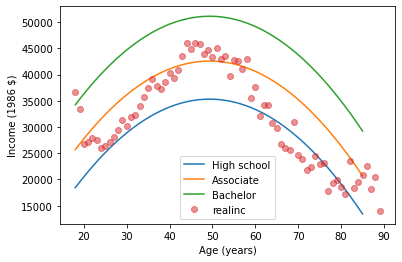

In [36]:
df = pd.DataFrame()
df['age'] = np.linspace(18,85)
df['age2'] = df['age']**2

df['educ'] = 12
df['educ2'] = df['educ']**2
pred12 = results.predict(df)
plt.plot(df['age'],pred12,label='High school')



df['educ'] = 14
df['educ2'] = df['educ']**2
pred14 = results.predict(df)
plt.plot(df['age'],pred14,label='Associate')



df['educ'] = 16
df['educ2'] = df['educ']**2
pred16 = results.predict(df)
plt.plot(df['age'],pred16,label='Bachelor')
plt.plot(mean_income_by_age,'o',alpha=.5,label='realinc')
plt.xlabel('Age (years)')
plt.ylabel('Income (1986 $)')
plt.legend(loc='best')
plt.show()

In [37]:
gss['gunlaw'].value_counts()

1.0    30918
0.0     9632
Name: gunlaw, dtype: int64

In [38]:
gss['gunlaw'].replace([2],[0],inplace=True)

In [49]:
formula = 'gunlaw ~ age + age2 + educ+ educ2 + C(sex)'
results = smf.logit(formula,data=gss).fit()
results.params

Optimization terminated successfully.
         Current function value: 0.533674
         Iterations 6


Intercept      1.653862
C(sex)[T.2]    0.757249
age           -0.018849
age2           0.000189
educ          -0.124373
educ2          0.006653
dtype: float64

In [50]:
df = pd.DataFrame()
df['age'] = np.linspace(18,89)
df['educ'] = 12

In [51]:
df['age2']=df['age']**2
df['educ2'] = df['educ']**2

In [53]:
df['sex']=1
pred1=results.predict(df)

df['sex'] = 2
pred2=results.predict(df)

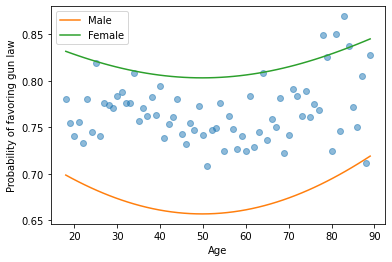

In [55]:
grouped=gss.groupby('age')
favor_by_age = grouped['gunlaw'].mean()
plt.plot(favor_by_age, 'o',alpha = .5)
plt.plot(df['age'],pred1,label='Male')
plt.plot(df['age'],pred2,label='Female')
plt.xlabel('Age')
plt.ylabel('Probability of favoring gun law')
plt.legend()

# 1. Limits of simple regression
In this chapter we'll get farther into regression, including multiple regression and one of my all-time favorite tools, logistic regression. But first let's understand the limits of simple regression.

2. Income and vegetables
In a previous exercise, you made a scatter plot of vegetable consumption as a function of income, and plotted a line of best fit. Here's what it looks like (note that this version includes more data than you had for the exercise). The slope of the line is 0 point 07, which means that the difference between the lowest and highest income brackets is about 0 point 49 servings per day. So that's not a very big difference.

3. Vegetables and income
But it was an arbitrary choice to plot vegetables as a function of income. We could have plotted it the other way around, like this. The slope of this line is 0 point 23, which means that the difference between 0 and 8 servings per day is about 2 income codes, roughly from code 5 to code 7. If we check the codebook, income code 5 is about $30,000 per year; income code 7 is about $65,000. So if we use vegetable consumption to predict income, we see a big difference. But when we used income to predict vegetable consumption, we saw a small difference. This example shows that regression is not symmetric; the regression of A onto B is not the same as the regression of B onto A.

4. Regression is not symmetric
We can see that more clearly by putting the two figures side by side and plotting both regression lines on both figures. They are different because they are based on different assumptions. On the left, we treat income as a known quantity and vegetable consumption as random. On the right, vegetable consumption is known and income is random. When you run a regression model, you make decisions about how to treat the data, and those decisions affect the result you get.

5. Regression is not causation
This example is meant to demonstrate another point, which is that regression doesn't tell you much about causation. If you think people with lower income can't afford vegetables, you might look at the figure on the left and conclude that it doesn't make much difference. If you think better diet increases income, the figure on the right might make you think it does. But in general, regression can't tell you what causes what. In this example, A might cause B, or B might cause A, or there might be other factors that cause both A and B. Regression alone can't tell you which way it goes.

6. Multiple regression
However, we have tools for teasing apart relationships among multiple variables; one of the most important is multiple regression. SciPy doesn't do multiple regression, so we have to switch to a new library, StatsModels. Here's the import statement. And here's how we use it. `ols` stands for "ordinary least squares", another name for regression. The first argument is a formula string that specifies that we want to regress income as a function of vegetable consumption. The second argument is the BRFSS DataFrame. The names in the formula correspond to columns in the DataFrame. The result from ols() represents the model; we have to run dot fit() to get the results. The results object contains a lot of information, but the first thing we'll look at is params, which contains the estimated slope and intercept. And we get the same results we got from SciPy, so that's good!

7. Let's practice!
In the next lesson we'll move on to multiple regression. But first, let's practice simple regression with statsmodels.

## Using StatsModels
Let's run the same regression using SciPy and StatsModels, and confirm we get the same results.

Instructions
100 XP
Compute the regression of '_VEGESU1' as a function of 'INCOME2' using SciPy's linregress().
Compute the regression of '_VEGESU1' as a function of 'INCOME2' using StatsModels' smf.ols().

In [42]:
from scipy.stats import linregress
import statsmodels.formula.api as smf

# Run regression with linregress
subset = brfss.dropna(subset=['INCOME2', '_VEGESU1'])
xs = subset['INCOME2']
ys = subset['_VEGESU1']
res = linregress(xs,ys)
print(res)

# Run regression with StatsModels
results = smf.ols('_VEGESU1 ~ INCOME2',data=brfss).fit()
print(results.params)

LinregressResult(slope=0.06988048092105006, intercept=1.5287786243363113, rvalue=0.11967005884864092, pvalue=1.378503916249654e-238, stderr=0.0021109763563323305, intercept_stderr=0.013196467544093591)
Intercept    1.528779
INCOME2      0.069880
dtype: float64


# . Multiple regression
Now that we are using StatsModels, getting from simple to multiple regression is easy. As an example, we'll use data from the General Social Survey, which we saw in Chapter 2, and we'll explore variables that are related to income.

2. Income and education
First, we load the GSS data. Then we run a regression of real income as a function of years of education. The first argument of ols() is a formula that specifies the variables in the regression. On the left, realinc is the variable we are trying to predict; on the right, educ is the variable we are using to inform the predictions. And here are the results. The estimated slope is 3586, which means that each additional year of education is associated with an increase of almost $3600 of income. But income also depends on age, so it would be good to include that in the model, too.

3. Adding age
Here's how. On the right side of the formula, you can list as many variables as you like, in this case, we have educ and age. The plus sign indicates that we expect the contributions of the two variables to be additive, which is a common assumption for models like this. Here are the results. The estimated slope for education is 3655, a little more than in the previous model. The estimated slope for age is only about $80 per year, which is surprisingly small.

4. Income and age
To see what's going on, let's look more closely at the relationship between income and age. I'll use groupby(), which is a Pandas feature we haven't seen before, to divide the DataFrame into age groups. The result is a GroupBy object that contains one group for each value of age. The GroupBy object behaves like a DataFrame in many ways. You can use brackets to select a column, like realinc in this example, and then invoke a method like mean(). The result is a Pandas series that contains the mean income for each age group, which we can plot like this.

5. Mean income over age
Here's the result. Average income increases from age 20 to age 50, then starts to fall. And that explains why the estimated slope is so small, because the relationship is non-linear. Remember that correlation and simple regression can't measure non-linear relationships. But multiple regression can!

6. Adding a quadratic term
To describe a non-linear relationship, one option is to add a new variable that is a non-linear combination of other variables. As an example, I'll create a new variable called age2 that equals age squared. Now we can run a regression with both age and age2 on the right side. And here are the results. The slope associated with age is substantial, about $1700 per year. The slope associated with age2 is about -17, which is harder to interpret.

7. Whew!
In the next lesson, we'll see methods to visualize regression results. But first, let's practice multiple regression.

## Plot income and education
To get a closer look at the relationship between income and education, let's use the variable 'educ' to group the data, then plot mean income in each group.

Here, the GSS dataset has been pre-loaded into a DataFrame called gss.



Group gss by 'educ'. Store the result in grouped.

From grouped, extract 'realinc' and compute the mean.

Plot mean_income_by_educ as a scatter plot. Specify 'o' and alpha=0.5.

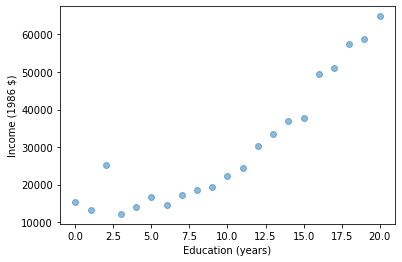

In [13]:
# Group by educ
grouped = gss.groupby('educ')

# Compute mean income in each group
mean_income_by_educ = grouped['realinc'].mean()

# Plot mean income as a scatter plot
plt.plot(mean_income_by_educ,'o',alpha=.5)

# Label the axes
plt.xlabel('Education (years)')
plt.ylabel('Income (1986 $)')
plt.show()

# Non-linear model of education
The graph in the previous exercise suggests that the relationship between income and education is non-linear. So let's try fitting a non-linear model.

Instructions
100 XP
Add a column named 'educ2' to the gss DataFrame; it should contain the values from 'educ' squared.
Run a regression model that uses 'educ', 'educ2', 'age', and 'age2' to predict 'realinc'.

In [14]:
import statsmodels.formula.api as smf

# Add a new column with educ squared
gss['educ2'] = gss['educ']**2

# Run a regression model with educ, educ2, age, and age2
results = smf.ols('realinc ~ educ + educ2 + age + age2',data=gss).fit()

# Print the estimated parameters
print(results.params)

Intercept   -23241.884034
educ          -528.309369
educ2          159.966740
age           1696.717149
age2           -17.196984
dtype: float64


## 1. Visualizing regression results
In the previous lesson we ran a multiple regression model to characterize the relationship between income and age. Because the model is non-linear, the parameters are hard to interpret. In this lesson we'll see a way to interpret them visually, and to validate them against data.

2. Modeling income and age
Here's the model from the previous exercise. First, we created new variables for educ squared and age squared. Then we ran the regression model with educ, educ2, age, and age2. And here are the results. The parameters are hard to interpret. Fortunately, we don't have to -- sometimes the best way to understand a model is by looking at its predictions rather than its parameters.

3. Generating predictions
The regression results object provides a method called predict() that uses the model to generate predictions. It takes a DataFrame as a parameter and returns a Series with a prediction for each row in the DataFrame. To use it, I'll create a new DataFrame with age running from 18 to 85, and age2 set to age squared. Next, I'll pick a level for educ, like 12 years, which is the most common value. When you assign a single value to a column in a DataFrame, Pandas makes a copy for each respondent. Then we can use results to predict the average income for each age group, holding education constant.

4. Plotting predictions
The result from predict() is a Series with one prediction for each row. So we can plot it like this, with age on the x-axis and the predicted income for each age group on the y-axis. We can plot the data for comparison, like this; recall that we computed mean_income_by_age in the previous lesson. And we should label the axes, as always.

5. Comparing with data
Here are the results. The blue dots show the average income in each age group. The orange line shows the predictions generated by the model, holding education constant. This plot shows the shape of the model, a downward-facing parabola.

6. Levels of education
We can do the same thing with other levels of education, like 14 years, which is the nominal time to earn an Associate's degree, and 16 years, which is the nominal time to earn a Bachelor's degree.

7. Interpreting the results
And here are the results. The lines show mean income, as predicted by the model, as a function of age, for three levels of education. This visualization helps validate the model since we can compare the predictions with the data. And it helps us interpret the model since we can see the separate contributions of age and education.

8. Let's practice!
In the exercises, you'll have a chance to run a multiple regression, generate predictions, and visualize the results. Have fun! 

## Making predictions
At this point, we have a model that predicts income using age, education, and sex.

Let's see what it predicts for different levels of education, holding age constant.

Instructions
100 XP
Using np.linspace(), add a variable named 'educ' to df with a range of values from 0 to 20.
Add a variable named 'age' with the constant value 30.
Use df to generate predicted income as a function of education.

# Making predictions
At this point, we have a model that predicts income using age, education, and sex.

Let's see what it predicts for different levels of education, holding age constant.

Instructions
100 XP
Using np.linspace(), add a variable named 'educ' to df with a range of values from 0 to 20.
Add a variable named 'age' with the constant value 30.
Use df to generate predicted income as a function of education.

In [32]:
# Run a regression model with educ, educ2, age, and age2
results = smf.ols('realinc ~ educ + educ2 + age + age2', data=gss).fit()

# Make the DataFrame
df = pd.DataFrame()
df['educ'] = np.linspace(0,20)
df['age'] = 30
df['educ2'] = df['educ']**2
df['age2'] = df['age']**2

# Generate and plot the predictions
pred = results.predict(df)
print(pred.head())

0    12182.344976
1    11993.358518
2    11857.672098
3    11775.285717
4    11746.199374
dtype: float64


# Visualizing predictions
Now let's visualize the results from the previous exercise!

Instructions
100 XP
Plot mean_income_by_educ using circles ('o'). Specify an alpha of 0.5.
Plot the prediction results with a line, with df['educ'] on the x-axis and pred on the y-axis.

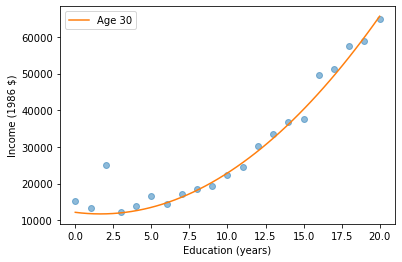

In [33]:
# Plot mean income in each age group
plt.clf()
grouped = gss.groupby('educ')
mean_income_by_educ = grouped['realinc'].mean()
plt.plot(mean_income_by_educ,'o',alpha=.5)

# Plot the predictions
pred = results.predict(df)
plt.plot(df['educ'], pred, label='Age 30')

# Label axes
plt.xlabel('Education (years)')
plt.ylabel('Income (1986 $)')
plt.legend()
plt.show()

# 1. Logistic regression
Congratulations on making it this far! I have saved one of my favorite topics for the end - logistic regression.

2. Categorical variables
To understand logistic regression, we have to start with categorical variables. Most of the variables we have used so far - like income, age, and education - are numerical. But variables like sex and race are categorical; that is, each respondent belongs to one of a specified set of categories.

3. Sex and income
With StatsModels, it is easy to include a categorical variable as part of a regression model. Here's how. In the formula string, the letter C indicates that sex is a categorical variable. And here are the results. The regression treats the value sex=1, which is male, as the default, and reports the difference associated with the value sex=2, which is female. So this result indicates that income for women is about $4100 less than for men, after controlling for age and education.

4. Boolean variable
If a categorical variable has only two values, it's called a boolean variable. For example, one of the questions in the General Social Survey asks "Would you favor or oppose a law which would require a person to obtain a police permit before he or she could buy a gun?" The variable is called gunlaw, and here are the values. 1 means yes and 2 means no, so most respondents are in favor. To explore the relationship between this variable and factors like age, sex, and education, we can use logistic regression. StatsModels provides logistic regression, but to use it, we have to recode the variable so 1 means yes and 0 means no. We can do that by replacing 2 with 0. And we can check the results.

5. Logistic regression
Now we can run the regression. Instead of ols(), we use logit(), which is named for the logit function, which is related to logistic regression. Other than that, everything is the same as what we have seen before. And here are the results. The parameters are in the form of "log odds", which you may or may not be familiar with. I won't explain them in detail here, except to say that positive values are associated with things that make the outcome more likely; negative values make the outcome less likely. For example, the parameter associated with sex=2 is 0.75, which indicates that women are more likely to support this form of gun control. To see how much more likely, we can generate and plot predictions, as we did with linear regression.

6. Generating predictions
As an example, I'll generate predictions for different ages and sexes, with education held constant. First we need a DataFrame with age and educ. Then we can compute age2 and educ2. We can generate predictions for men like this. And for women like this.

7. Visualizing results
Now, to visualize the results, I start by plotting the data. As we've done before, we'll divide the respondents into age groups and compute the mean in each group. The mean of a binary variable is the fraction of people in favor. Now we can plot the predictions, for men and women, as a function of age. And label the axes.

8. Gun laws and age
Here's what it looks like. According to the model, people near age 50 are least likely to support gun control (at least as this question was posed). And women are more likely to support it than men, by almost 15 percentage points.

9. Let's practice!
Logistic regression is a powerful tool for exploring relationships between a binary variable and the factors that predict it. In the exercises, you'll explore the factors that predict support for legalizing marijuana.

## Predicting a binary variable
Let's use logistic regression to predict a binary variable. Specifically, we'll use age, sex, and education level to predict support for legalizing cannabis (marijuana) in the U.S.

In the GSS dataset, the variable grass records the answer to the question __***"Do you think the use of marijuana should be made legal or not?"***

Instructions 1/4
35 XP
1
2
3
4
Fill in the parameters of smf.logit() to predict grass using the variables age, age2, educ, and educ2, along with sex as a categorical variable.

In [57]:
# Recode grass
gss['grass'].replace(2, 0, inplace=True)

# Run logistic regression
results = smf.logit('grass ~ age + age2+ educ+ educ2+ C(sex)', data=gss).fit()
results.params

Optimization terminated successfully.
         Current function value: 0.588510
         Iterations 6


Intercept     -1.685223
C(sex)[T.2]   -0.384611
age           -0.034756
age2           0.000192
educ           0.221860
educ2         -0.004163
dtype: float64

# Predicting a binary variable
Let's use logistic regression to predict a binary variable. Specifically, we'll use age, sex, and education level to predict support for legalizing cannabis (marijuana) in the U.S.

In the GSS dataset, the variable grass records the answer to the question "Do you think the use of marijuana should be made legal or not?"

Optimization terminated successfully.
         Current function value: 0.588510
         Iterations 6


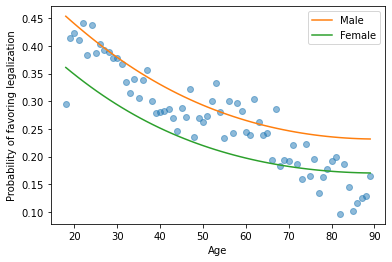

In [58]:
# Recode grass
gss['grass'].replace(2, 0, inplace=True)

# Run logistic regression
results = smf.logit('grass ~ age + age2 + educ + educ2 + C(sex)', data=gss).fit()
results.params

# Make a DataFrame with a range of ages
df = pd.DataFrame()
df['age'] = np.linspace(18, 89)
df['age2'] = df['age']**2

# Set the education level to 12
df['educ'] = 12
df['educ2'] = df['educ']**2

# Generate predictions for men and women
df['sex'] = 1
pred1 = results.predict(df)

df['sex'] = 2
pred2 = results.predict(df)

plt.clf()
grouped = gss.groupby('age')
favor_by_age = grouped['grass'].mean()

plt.plot(favor_by_age, 'o', alpha=0.5)

plt.plot(df['age'], pred1, label='Male')
plt.plot(df['age'], pred2, label='Female')

plt.xlabel('Age')
plt.ylabel('Probability of favoring legalization')
plt.legend()
plt.show()


Got It!
1. Next steps
Congratulations on completing the course! We covered a lot of material. I hope you found it useful and interesting. At this point, I'd like to summarize the topics we covered, and make some connections that might clarify the big picture. And I'll suggest some resources you can explore next.

2. Exploratory Data Analysis
The organizing theme of this course is exploratory data analysis, which is a process and a set of techniques for working with data, especially in the early stages of a project, or when you are working with a new data set. The four chapters in this course are the steps of this process: - Chapter 1 is about importing and cleaning the data, and checking for errors and other special conditions. This might not be the most exciting part of the process, but if you skip these steps, it can come back to haunt you. Time spent cleaning and validating data can save you from embarrassing, and sometimes expensive, errors. - Chapter 2 is about exploring variables one at a time, visualizing distributions using PMFs, CDFs, and KDE, and choosing appropriate summary statistics. - In Chapter 3 we explored relationships between variables two at a time, using scatter plots and other visualizations; and we quantified those relationships using correlation and simple regression. - Finally, in Chapter 4, we explored multivariate relationships using multiple regression and logistic regression.

3. Import, clean, and validate
From Chapter 1, you might remember that we looked at the distribution of birth weights from the National Survey of Family Growth. If you only remember one thing, remember the 99 pound babies, and how much it can mess up your results if you don't validate the data.

4. Visualize distributions
In Chapter 2 we looked at the distributions of age, income, and other variables from the General Social Survey.

5. CDF, PMF, and KDE
I recommended using CDFs as the best way to explore distributions. But when you present to audiences that are not familiar with CDFs, you can use PMFs if there are a small number of unique values, and KDE if there are a lot.

6. Visualizing relationships
In Chapter 3 we looked at heights and weights from the BRFSS, and developed several ways to visualize relationships between variables, including scatter plots, violin plots, and box plots like this one.

7. Quantifying correlation
We used the coefficient of correlation to quantify the strength of a relationship. We also used simple regression to find the line of best fit, like the one here that shows weight as a function of height. But remember that both of these methods only capture linear relationships; if the relationship is non-linear, they can be misleading. Always look at a visualization, like this scatter plot, before computing correlation or simple regression.

8. Multiple regression
In Chapter 4 we used multiple regression to add control variables and to describe non-linear relationships. For example, this plot shows the non-linear relationship between income and age, controlling for level of education.

9. Logistic regression
And finally we used logistic regression to explain and predict binary variables. For example, this figure shows the relationship between support for gun control, as a function of age, for male and female respondents in the GSS.

10. Where to next?
This course makes a great foundation for other DataCamp courses. Maybe you may want to learn more about CDFs, or data visualization, or pandas. DataCamp has courses that cover all of these topics and more, and I encourage you to check them out. On this slide are a few recommended next courses.

11. Think Stats
And if you'd like to review the material from this course, and learn additional topics like time series analysis, you could read my book, called Think Stats. It's published by O'Reilly Media and also available under a free license at thinkstats2.com.

12. Thank you!
Finally, I hope you found this course useful, and I hope you had some fun and learned a lot. Thank you!